In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import class_weight

In [3]:
df = pd.read_csv("/kaggle/input/dataset/balanced_data_with_rounded_severity.csv")

In [4]:
df.head()

,hypothesis,premise,s1,s2,label,contradiction_severity_score
0,the paper is clearly written and to my knowled...,while the paper is very clear with respects to...,negative,positive,1,3
1,trannorm is well motivated separately normaliz...,this line of attack against the domain-adaptat...,negative,positive,1,5
2,active perception and more specifically recogn...,i am not convinced about the novelty and contr...,negative,positive,1,5
3,in other words the proposed method makes sense...,the topic of the paper is interesting and the ...,negative,positive,1,4
4,- experimental results are quite promising as ...,furthermore evaluations seem rather noisy to m...,negative,positive,1,5


In [5]:
count_0 = df[df['label'] == 0].shape[0]

count_1 = df[df['label'] == 1].shape[0]

print("Number of rows where 'label' is 0:", count_0)
print("Number of rows where 'label' is 1:", count_1)

Number of rows where 'label' is 0: 16007
Number of rows where 'label' is 1: 5725


In [6]:
df.columns

Index(['hypothesis', 'premise', 's1', 's2', 'label',
       'contradiction_severity_score'],
      dtype='object')

In [7]:
df['label'] = df['label'].replace({'c': 1, 'n': 0})

In [8]:
df.head()

,hypothesis,premise,s1,s2,label,contradiction_severity_score
0,the paper is clearly written and to my knowled...,while the paper is very clear with respects to...,negative,positive,1,3
1,trannorm is well motivated separately normaliz...,this line of attack against the domain-adaptat...,negative,positive,1,5
2,active perception and more specifically recogn...,i am not convinced about the novelty and contr...,negative,positive,1,5
3,in other words the proposed method makes sense...,the topic of the paper is interesting and the ...,negative,positive,1,4
4,- experimental results are quite promising as ...,furthermore evaluations seem rather noisy to m...,negative,positive,1,5


In [9]:
df.shape

(21732, 6)

In [10]:
import tensorflow as tf

from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout, GlobalMaxPooling1D, Dot

In [11]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df[['hypothesis', 'premise']]
y_label = df['label']
y_severity = df['contradiction_severity_score'] 

In [14]:
X_train, X_test, y_train_label, y_test_label, y_train_severity, y_test_severity = train_test_split(
    X, y_label, y_severity, test_size=0.3, random_state=42
)

In [15]:
max_sequence_length = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['hypothesis'] + X_train['premise'])


In [16]:
X_train_seq_A = tokenizer.texts_to_sequences(X_train['hypothesis'])
X_train_seq_B = tokenizer.texts_to_sequences(X_train['premise'])
X_test_seq_A = tokenizer.texts_to_sequences(X_test['hypothesis'])
X_test_seq_B = tokenizer.texts_to_sequences(X_test['premise'])

X_train_padded_A = pad_sequences(X_train_seq_A, maxlen=max_sequence_length)
X_train_padded_B = pad_sequences(X_train_seq_B, maxlen=max_sequence_length)
X_test_padded_A = pad_sequences(X_test_seq_A, maxlen=max_sequence_length)
X_test_padded_B = pad_sequences(X_test_seq_B, maxlen=max_sequence_length)

In [17]:
X_train_combined = np.hstack((X_train_padded_A, X_train_padded_B))
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_label_res = ros.fit_resample(X_train_combined, y_train_label)

y_train_severity_res = y_train_severity.iloc[ros.sample_indices_].values

X_train_res_A = X_train_res[:, :max_sequence_length]
X_train_res_B = X_train_res[:, max_sequence_length:]

In [18]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

In [19]:
input_A = Input(shape=(max_sequence_length,))
input_B = Input(shape=(max_sequence_length,))


In [20]:
def attention_mechanism(inputs):
    attention_scores = Dense(max_sequence_length, activation='softmax')(inputs)
    context_vector = Dot(axes=[1, 1])([attention_scores, inputs])
    return context_vector

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
embedded_A = embedding_layer(input_A)
embedded_B = embedding_layer(input_B)

lstm_layer = LSTM(64, return_sequences=True)
lstm_output_A = lstm_layer(embedded_A)
lstm_output_B = lstm_layer(embedded_B)

attention_A = attention_mechanism(lstm_output_A)
attention_B = attention_mechanism(lstm_output_B)

pooled_A = GlobalMaxPooling1D()(attention_A)
pooled_B = GlobalMaxPooling1D()(attention_B)

pooled_A = Dropout(0.5)(pooled_A)
pooled_B = Dropout(0.5)(pooled_B)

concatenated_output = concatenate([pooled_A, pooled_B], axis=-1)
concatenated_output = Dropout(0.5)(concatenated_output)

dense_layer = Dense(64, activation='relu')(concatenated_output)

label_output = Dense(1, activation='sigmoid', name='label_output')(dense_layer)

severity_output = Dense(1, activation='linear', name='severity_output')(dense_layer)

model = Model(inputs=[input_A, input_B], outputs=[label_output, severity_output])


In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  1,273,100 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 64)   │     42,240 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 100)  │      6,500 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 100)  │      6,500 │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 100, 64)   │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 100, 64)   │          0 │ dense_1[0][0],    │
│                     │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dot[0][0]         │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dot_1[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_output        │ (None, 1)         │         65 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ severity_output     │ (None, 1)         │         65 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,336,726 (5.10 MB)

 Trainable params: 1,336,726 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

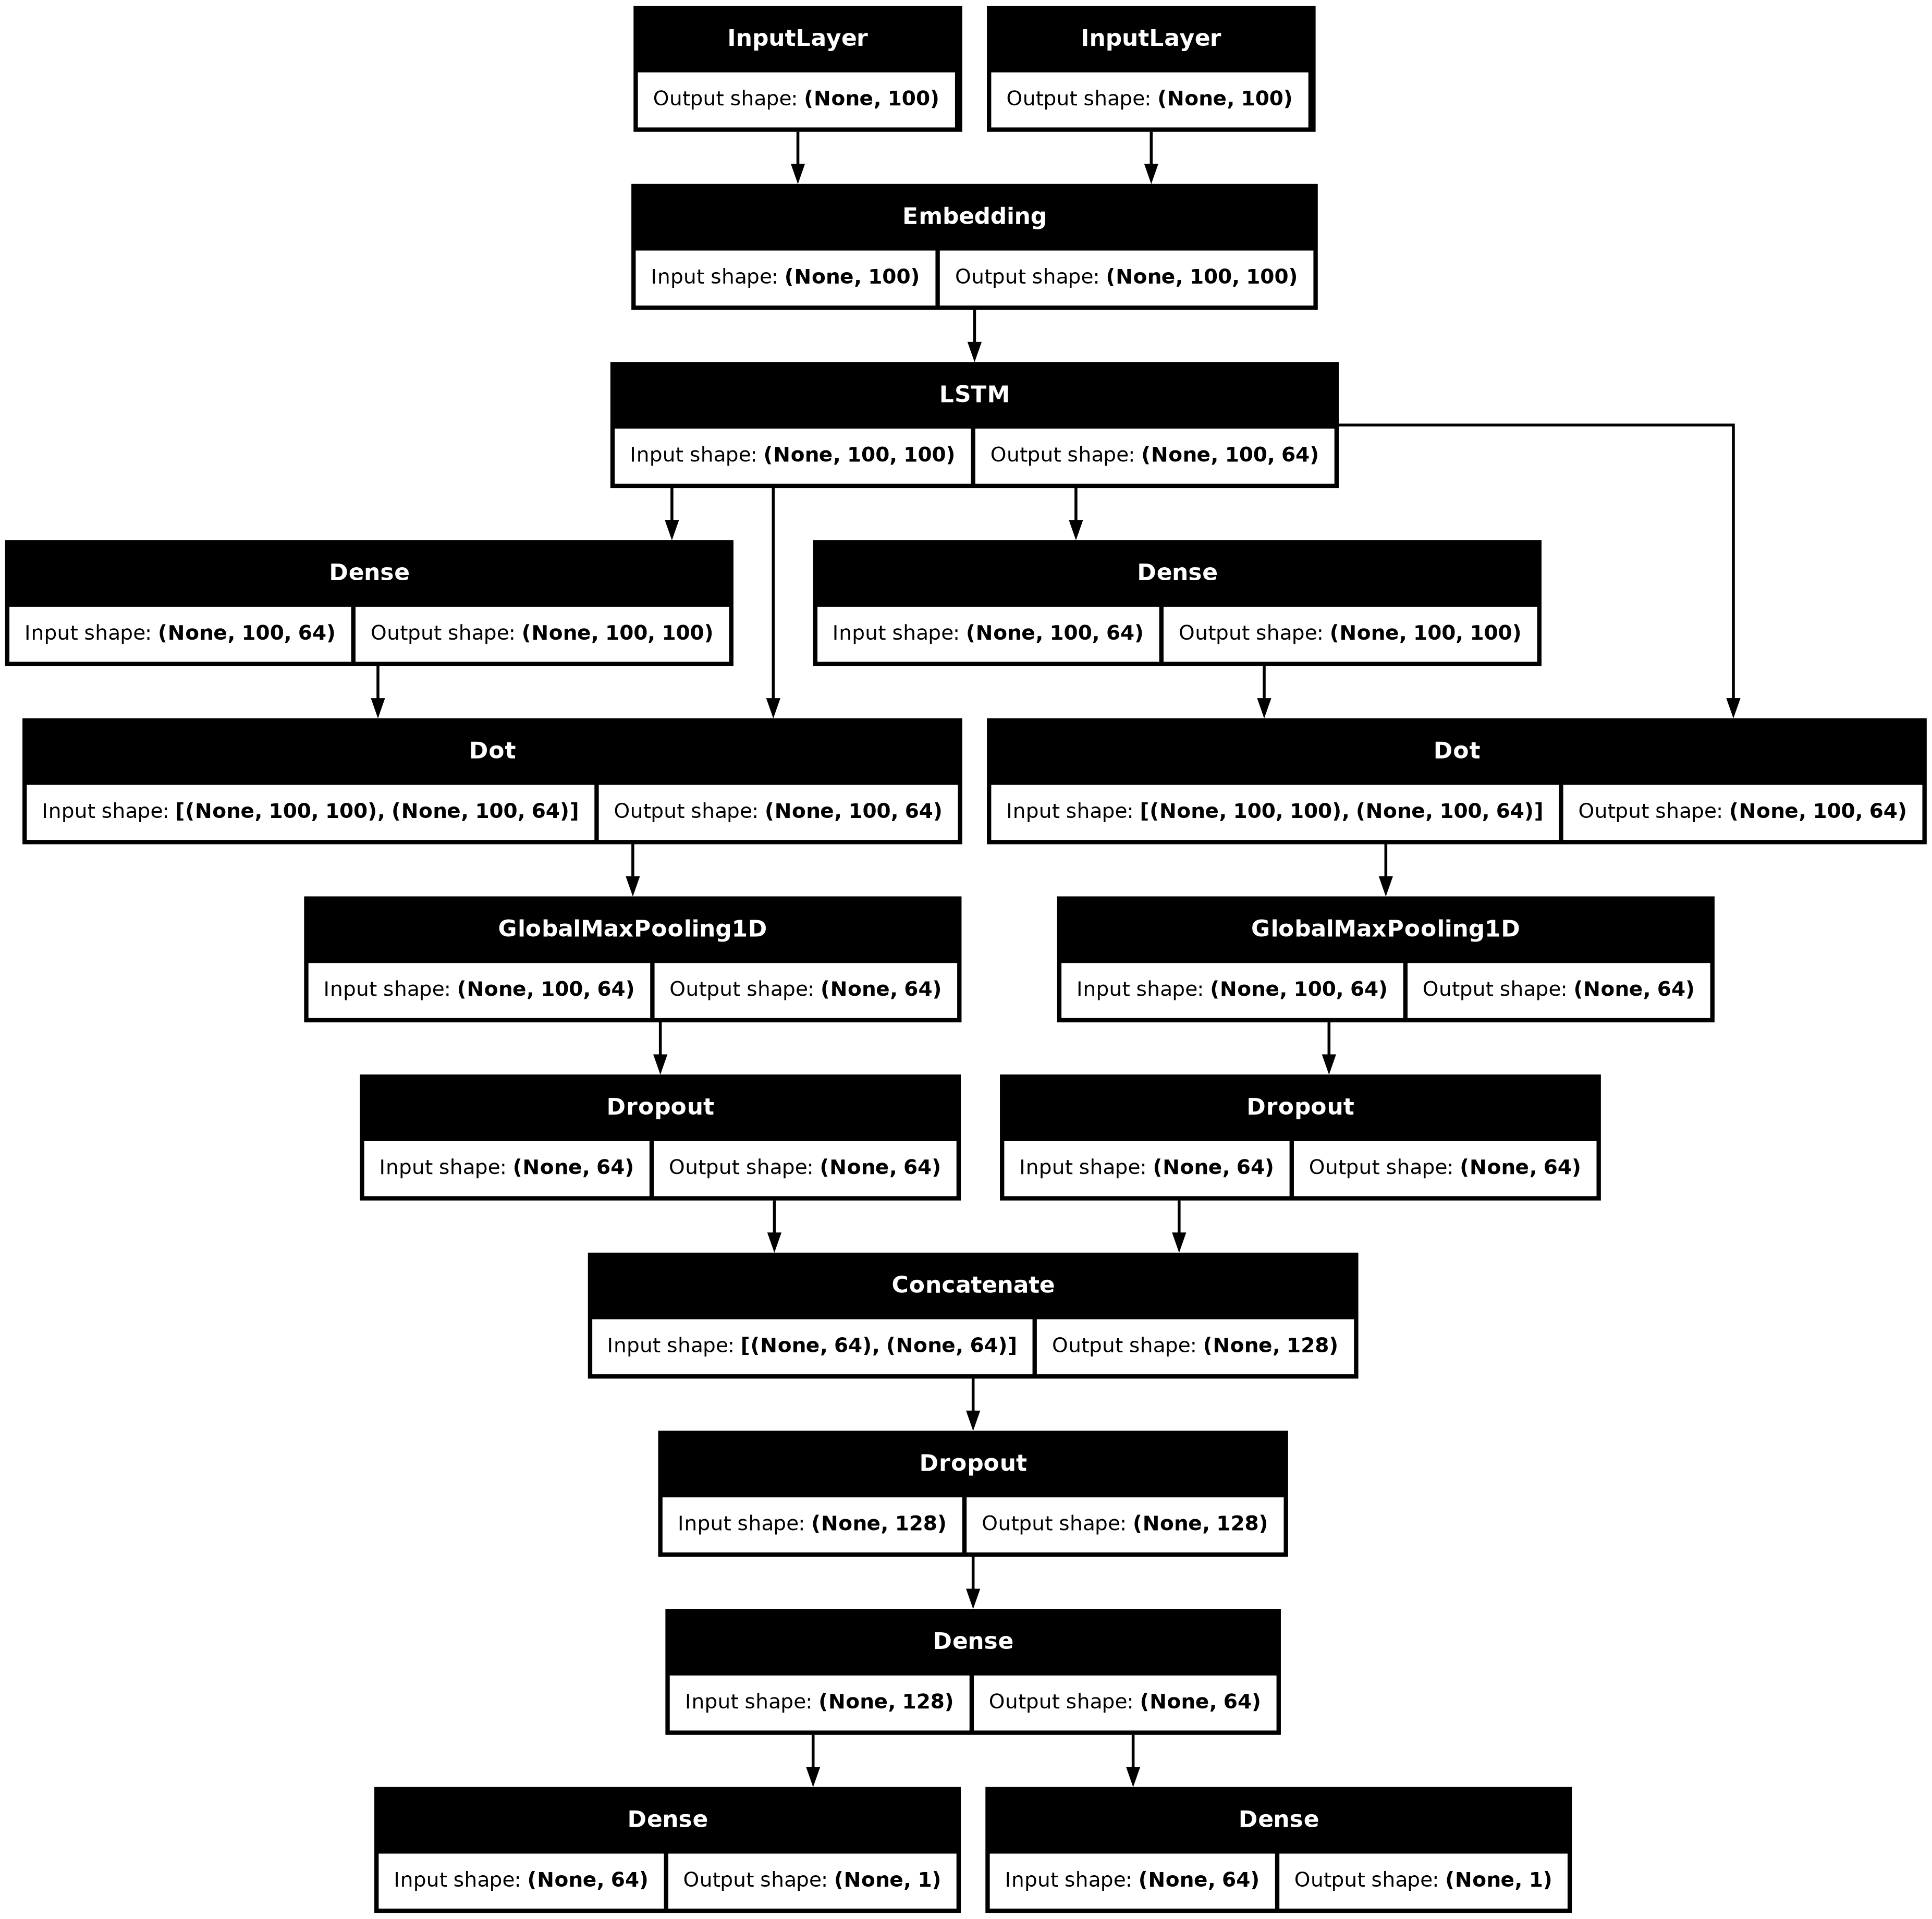

In [22]:
tf.keras.utils.plot_model(model,to_file='multi-task_model.png', show_shapes=True)

In [23]:
model.compile(optimizer='adam', 
              loss={'label_output': 'binary_crossentropy', 'severity_output': 'mean_squared_error'},
              metrics={'label_output': 'accuracy', 'severity_output': 'mean_absolute_error'})


In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.keras', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [25]:
epochs = 50
batch_size = 64

history = model.fit(
    x=[X_train_res_A, X_train_res_B], 
    y={'label_output': y_train_label_res, 'severity_output': y_train_severity_res}, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=callbacks
)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - label_output_accuracy: 0.6197 - loss: 6.6403 - severity_output_mean_absolute_error: 2.2259 - val_label_output_accuracy: 0.3649 - val_loss: 10.1135 - val_severity_output_mean_absolute_error: 2.9372
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - label_output_accuracy: 0.6867 - loss: 5.4732 - severity_output_mean_absolute_error: 1.9183 - val_label_output_accuracy: 0.6924 - val_loss: 7.0708 - val_severity_output_mean_absolute_error: 2.2759
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - label_output_accuracy: 0.7743 - loss: 4.4774 - severity_output_mean_absolute_error: 1.6083 - val_label_output_accuracy: 0.6978 - val_loss: 7.1597 - val_severity_output_mean_absolute_error: 2.2702
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - label_output_accuracy: 0.8193 - loss: 3.8748 - severity_output_mean_absolute_error: 1.4208 - val_label_output_accuracy: 0.8418 - val_loss: 4.5122 - val_severity_output_mean_absolute_error: 1

In [26]:
loss, accuracy, mae = model.evaluate(x=[X_test_padded_A, X_test_padded_B], 
                                     y=[y_test_label, y_test_severity])
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy (Label): {accuracy:.4f}')
print(f'Test MAE (Severity Score): {mae:.4f}')

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - label_output_accuracy: 0.7199 - loss: 6.7003 - severity_output_mean_absolute_error: 1.6737
Test loss: 6.7085
Test accuracy (Label): 0.7195
Test MAE (Severity Score): 1.6710


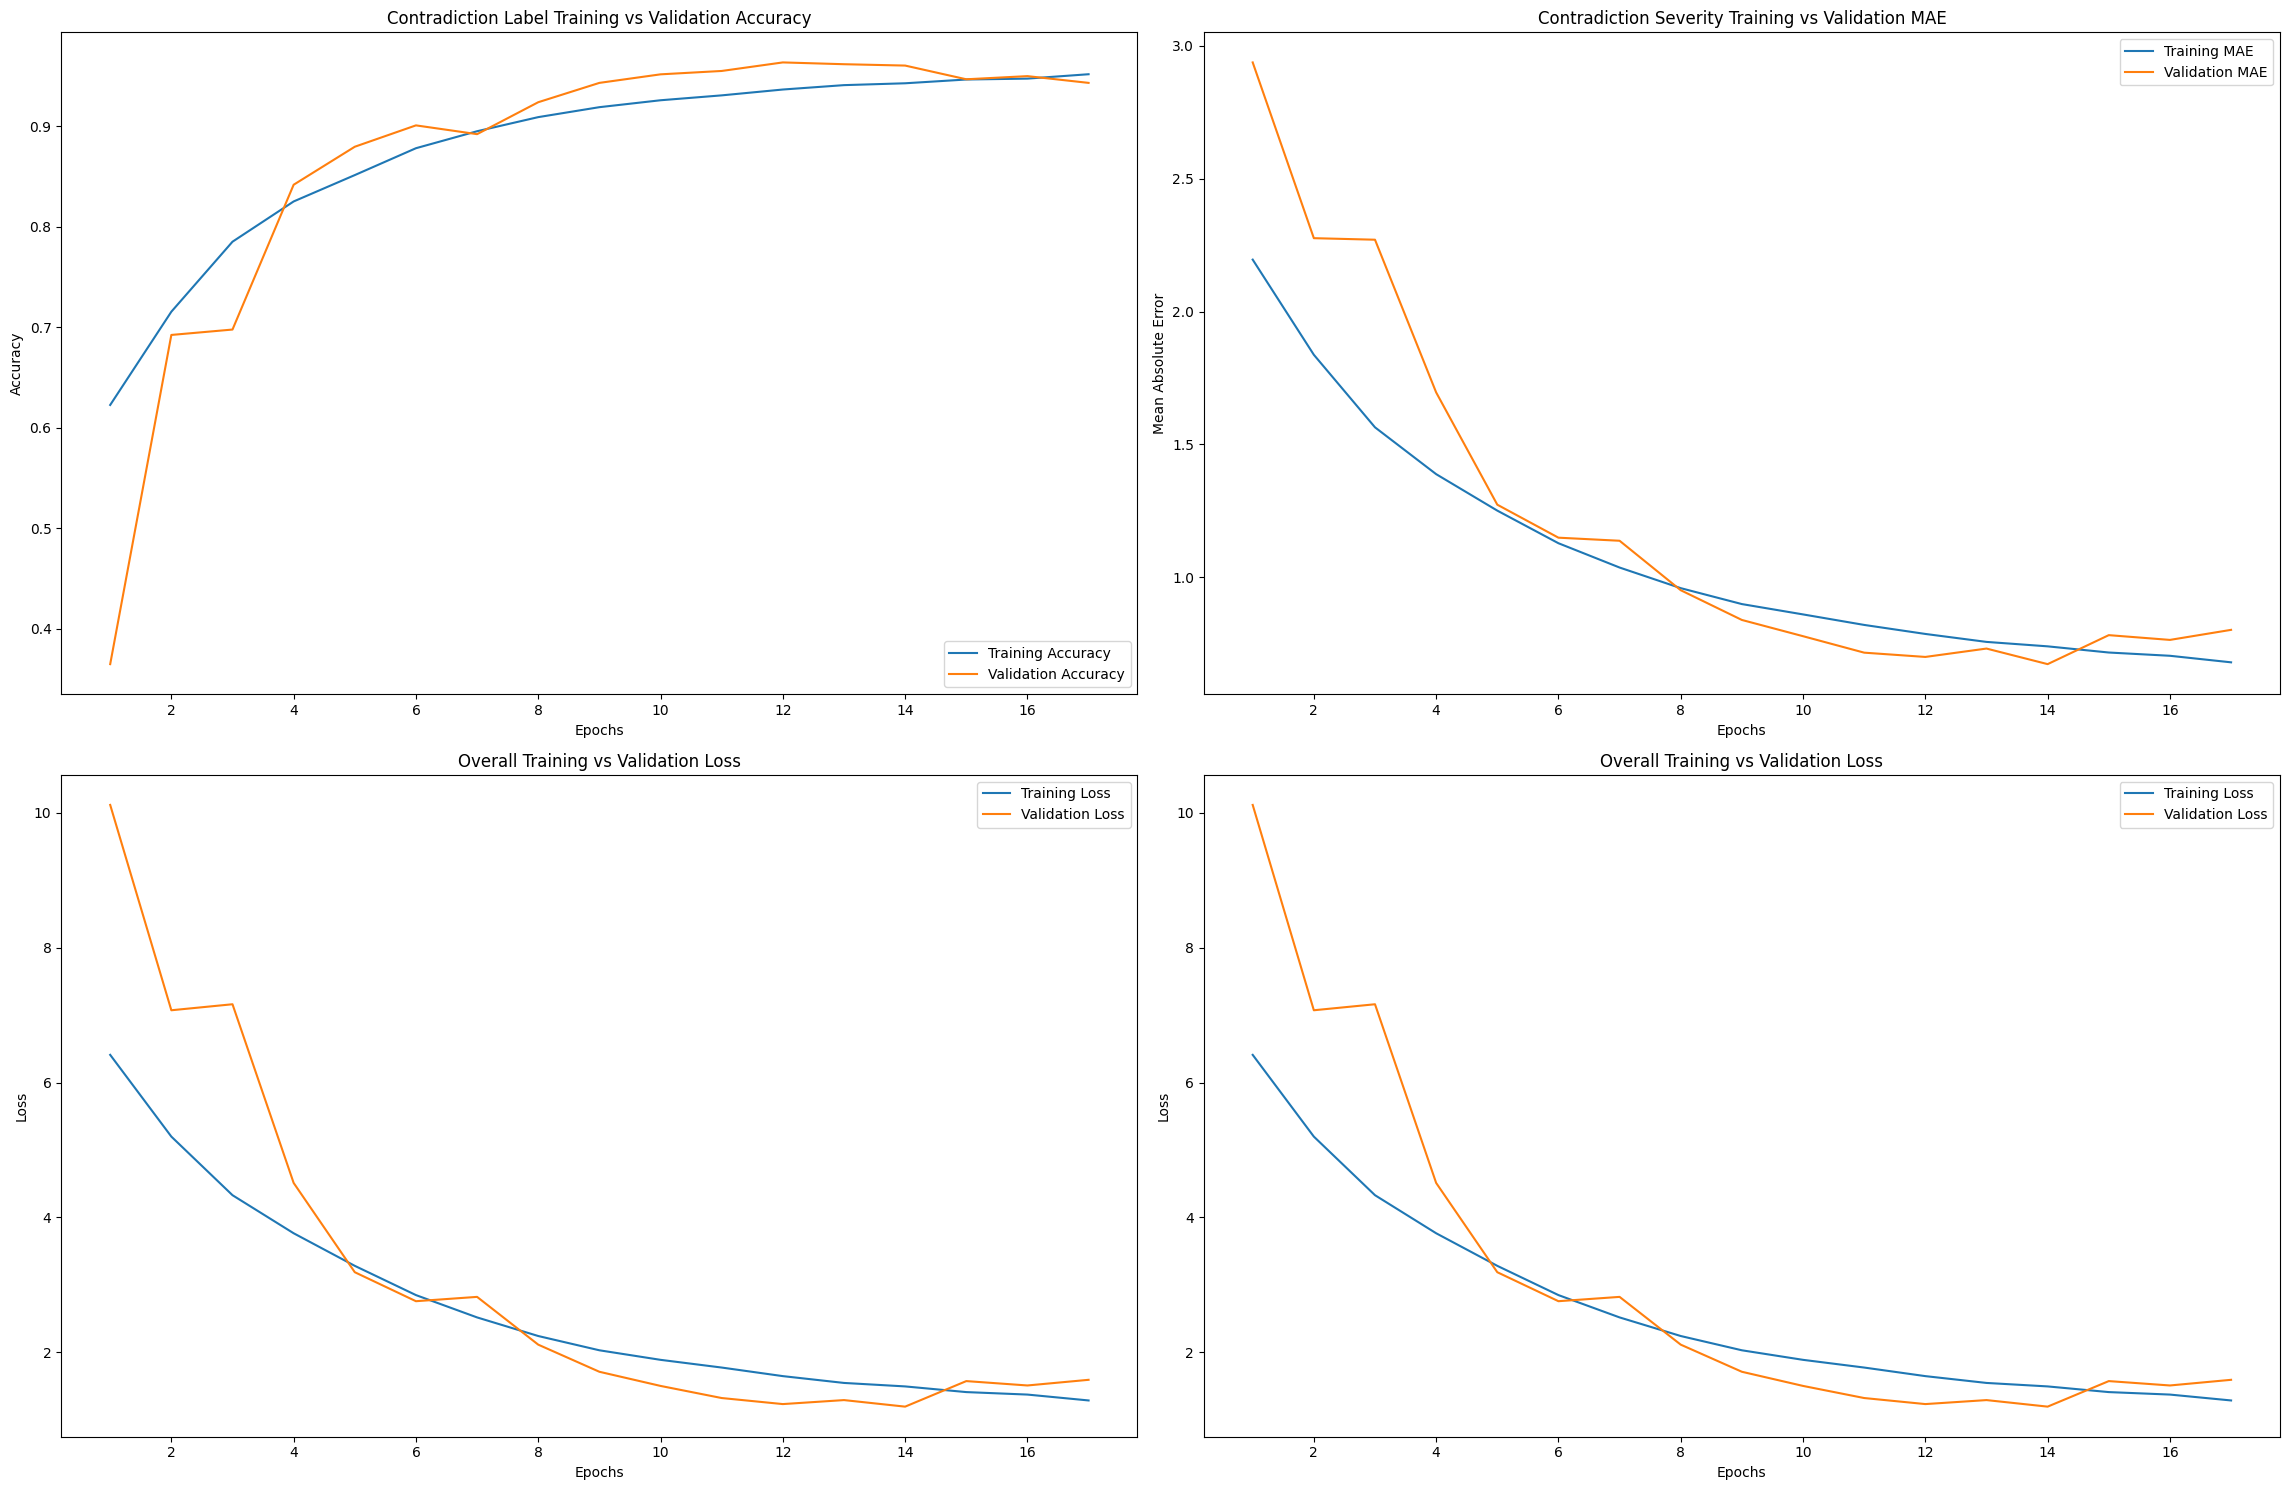

In [27]:
import matplotlib.pyplot as plt

metrics = history.history
epochs_range = range(1, len(metrics['loss']) + 1)

plt.figure(figsize=(23, 15))

# Label Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, metrics['label_output_accuracy'], label='Training Accuracy')
plt.plot(epochs_range, metrics['val_label_output_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Contradiction Label Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Severity MAE
plt.subplot(2, 2, 2)
plt.plot(epochs_range, metrics['severity_output_mean_absolute_error'], label='Training MAE')
plt.plot(epochs_range, metrics['val_severity_output_mean_absolute_error'], label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Contradiction Severity Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

# Label Loss
plt.subplot(2, 2, 3)
plt.plot(epochs_range, metrics['loss'], label='Training Loss')
plt.plot(epochs_range, metrics['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Overall Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Severity Loss
plt.subplot(2, 2, 4)
plt.plot(epochs_range, metrics['loss'], label='Training Loss')
plt.plot(epochs_range, metrics['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Overall Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [28]:
def predict_contradiction(sentence_A, sentence_B, model):
    test_seq_A = tokenizer.texts_to_sequences([sentence_A])
    test_seq_B = tokenizer.texts_to_sequences([sentence_B])
    test_padded_A = pad_sequences(test_seq_A, maxlen=max_sequence_length)
    test_padded_B = pad_sequences(test_seq_B, maxlen=max_sequence_length)

    predictions = model.predict([test_padded_A, test_padded_B])

    print(f"Prediction (probability of contradiction): {predictions[0][0][0]:.4f}")
    print(f"Predicted Contradiction Severity Score: {predictions[1][0][0]:.4f}")
    if predictions[0][0][0] > 0.5:
        print("Prediction: Contradiction")
    else:
        print("Prediction: No Contradiction")

In [29]:
sentence_A = "further the paper makes several misleading claims."
sentence_B = "the paper is rather well written but it strongly lacks precision about the proposed method."
predict_contradiction(sentence_A, sentence_B, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Prediction (probability of contradiction): 0.0008
Predicted Contradiction Severity Score: -0.6100
Prediction: No Contradiction


In [30]:
sentence_A = "2 .this paper is not very easy to follow ."
sentence_B = "this paper is well written and the information is very intensive whereby closely related works are well covered ."
predict_contradiction(sentence_A,sentence_B,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.9837
Predicted Contradiction Severity Score: 4.2427
Prediction: Contradiction


## Testing

In [31]:
# Test the function with example inputs
hypothesis = "2 .this paper is not very easy to follow ."
premise = "this paper is well written and the information is very intensive whereby closely related works are well covered ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.9837
Predicted Contradiction Severity Score: 4.2427
Prediction: Contradiction


In [32]:
# Test the function with example inputs
hypothesis = "further the paper makes several misleading claims ."
premise = "the paper is rather well written but it strongly lacks precision about the proposed method ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction (probability of contradiction): 0.0008
Predicted Contradiction Severity Score: -0.6100
Prediction: No Contradiction


In [33]:
# Test the function with example inputs
hypothesis = "to summarize i think this paper give some empirical support for the effectiveness of is yet the theoretical side is not ready ."
premise = "this paper is decently written and the experimental results look promising ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.0387
Predicted Contradiction Severity Score: -0.2796
Prediction: No Contradiction


In [34]:
# Test the function with example inputs
hypothesis = "this paper reads well and the results appear sound ."
premise = "2 choosing 10 % triples as positive training examples seems very ad-hoc ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction (probability of contradiction): 0.0402
Predicted Contradiction Severity Score: -0.2867
Prediction: No Contradiction


In [35]:
# Test the function with example inputs
hypothesis = "some important explanation of the methods is missing ."
premise = "beyond this the experimental performance of the authors ' method seems quite good on the tasks considered and at least a substantial subset of the baselines considered are recent ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.0352
Predicted Contradiction Severity Score: -0.2982
Prediction: No Contradiction


In [36]:
# Test the function with example inputs
hypothesis = "although it looks to me that leveraging drop-out in neural networks to better learn the feature-based model to help cold-start is a great idea in this paper the methodology is not clearly written to be fully convincing ."
premise = "beyond this the experimental performance of the authors ' method seems quite good on the tasks considered and at least a substantial subset of the baselines considered are recent ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.0133
Predicted Contradiction Severity Score: -0.3813
Prediction: No Contradiction


In [37]:
# Test the function with example inputs
hypothesis = "on the back of so much hope and expectation built-up in the introduction the solution put forward in the paper strikes us as a curious but a hardly useful toy ."
premise = "overall evaluation the core idea is novel simple and extensive tests show that it is effective ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.0004
Predicted Contradiction Severity Score: -0.6823
Prediction: No Contradiction


In [38]:
# Test the function with example inputs
hypothesis = "2 not too many qualitative results are provided for each experiment "
premise = "overall evaluation the core idea is novel simple and extensive tests show that it is effective ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction (probability of contradiction): 0.0222
Predicted Contradiction Severity Score: -0.3408
Prediction: No Contradiction


In [39]:
# Test the function with example inputs
hypothesis = " the paper is well motivated and clearly written ."
premise = "the motivation of the paper would be much better tested on these tasks ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.7445
Predicted Contradiction Severity Score: 3.0103
Prediction: Contradiction


In [40]:
# Test the function with example inputs
hypothesis = " addition are unclear ."
premise = " good experimental performance on multiple sequence modeling tasks including addition multiplication and sequence mnist ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.8605
Predicted Contradiction Severity Score: 3.7018
Prediction: Contradiction


In [41]:
# Test the function with example inputs
hypothesis = "one drawback is that the main computations are only tractable in toy domains - it would be good if they discussed how to use this with general neural model with large state spaces e.g .states obtained with an rnn ."
premise = "the topic is very interesting and not studied enough the proposed method looks novel and the experimental results look promising ."

# Get the prediction
predict_contradiction(hypothesis, premise, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction (probability of contradiction): 0.0166
Predicted Contradiction Severity Score: -0.3249
Prediction: No Contradiction


## Saving

In [42]:
import tensorflow as tf

def save_model(model, model_path='/kaggle/working/saved_lstm_model.h5'):
    model.save(model_path)
    print(f"Model saved to {model_path}")

save_model(model, '/kaggle/working/saved_lstm_model.h5')

Model saved to /kaggle/working/saved_lstm_model.h5
